# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/yovan/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path, cha

In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

In [3]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
napari.run()

## Starting a Dask Client for parallelization

In [4]:
from nuclear_analysis import segmentation
from tracking import track_features, detect_mitosis

import numpy as np
from dask.distributed import LocalCluster, Client

In [5]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

2023-07-24 22:44:59,333 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zvh2ydjd', purging


In [6]:
client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:41185,Total threads: 1
Dashboard: http://127.0.0.1:44633/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:37635,


## Nuclear segmentation and tracking

In [8]:
%%time

(
    denoised,
    denoised_futures,
    nuclear_channel_futures,
) = segmentation.denoise_movie_parallel(
    nuclear_channel,
    denoising="gaussian",
    denoising_sigma=3,
    client=client,
)

mask, mask_futures, _ = segmentation.binarize_movie_parallel(
    denoised_futures,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(3, 3),
    client=client,
    futures_in=False,
)

markers, markers_futures, _ = segmentation.mark_movie_parallel(
    *nuclear_channel_futures,  # Wrapped in list from previous parallel run, needs unpacking
    mask_futures,
    low_sigma=[3, 5.5, 5.5],
    high_sigma=[10, 14.5, 14.5],
    max_footprint=((1, 25), segmentation.ellipsoid(3, 3)),
    max_diff=1,
    client=client,
    futures_in=False,
)

marker_coords = np.array(np.nonzero(markers)).T

labels, labels_futures, _ = segmentation.segment_movie_parallel(
    denoised_futures,
    markers_futures,
    mask_futures,
    watershed_method="raw",
    min_size=200,
    client=client,
    futures_in=False,
)

segmentation_dataframe = track_features.segmentation_df(
    labels,
    nuclear_channel,
    nuclear_channel_metadata,
)

tracked_dataframe = track_features.link_df(
    segmentation_dataframe,
    search_range=15,
    # adaptive_stop=1,
    # adaptive_step=0.99,
    memory=0,
    pos_columns=["x", "y"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=2,
)

centroids = np.unique(
    np.array(
        [
            [row["frame"] - 1, int(row["z"]), int(row["y"]), int(row["x"])]
            for _, row in tracked_dataframe.iterrows()
        ]
    ),
    axis=0,
)

mitosis_dataframe = detect_mitosis.construct_lineage(
    tracked_dataframe,
    pos_columns=["y", "x"],
    search_range_mitosis=35,
    # adaptive_stop=0.05,
    # adaptive_step=0.99,
    antiparallel_coordinate="collision",
    antiparallel_weight=None,
    min_track_length=3,
    image_dimensions=[256, 512],
    exclude_border=0.02,
    minimum_age=8,
)

reordered_labels, reordered_labels_futures, _ = track_features.reorder_labels_parallel(
    labels_futures,
    mitosis_dataframe,
    client=client,
    futures_in=False,
    futures_out=True,
)

Frame 2: 32 trajectories present.
CPU times: user 1min 20s, sys: 19.4 s, total: 1min 40s
Wall time: 4min


Using the rule of thumb $r \approx \sigma \sqrt{2} \ (2D)$ and $r \approx \sigma \sqrt{3} \ (3D)$ as rough bounds for the kernels used for band-pass filtering seems to net a perfect segmentation.

In [9]:
viewer.add_labels(reordered_labels)

<Labels layer 'reordered_labels' at 0x7fd2bc7a1e70>

In [10]:
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)

## Spot segmentation and fitting

In [11]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [12]:
viewer.add_image(transcription_channel, name="Transcription Channel")

<Image layer 'Transcription Channel' at 0x7fd3338eb4c0>

In [13]:
from spot_analysis import detection, fitting

In [14]:
%%time

spot_dataframe, spot_mask, bandpassed_movie = detection.detect_and_gather_spots(
    transcription_channel,
    frame_metadata=transcription_channel_metadata,
    low_sigma=[0.1, 0.5, 0.5],
    high_sigma=[3, 1.5, 1.5],
    threshold="triangle",
    min_size=6,
    connectivity=1,
    span=[5, 11, 11],
    pos_columns=["z", "y", "x"],
    return_bandpass=False,
    return_spot_mask=True,
    drop_reverse_time=True,
    client=client,
)

fitting.add_fits_spots_dataframe_parallel(
    spot_dataframe,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    client=client,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
    inplace=True,
)

CPU times: user 17.6 s, sys: 5.11 s, total: 22.7 s
Wall time: 56.1 s


In [15]:
spot_dataframe

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,sigma_x_y,sigma_z,amplitude,offset,cost,norm_cost,intensity_from_fit
0,436,5.901674,60.149073,308.473986,1,4.305350,0,"[[[1601, 1631, 1418, 1034, 1458, 1227, 680, 15...","[0, 3, 54, 303]",0.842110,0.690278,4478.519850,1265.532016,4.714938e+07,0.003584,34527.592870
1,460,6.804033,170.582886,373.563045,1,4.949140,0,"[[[1668, 1243, 1281, 2169, 1157, 1535, 1252, 1...","[0, 4, 165, 368]",0.822731,0.772539,12564.859584,1329.326717,5.583090e+07,0.001390,103481.723648
2,534,8.292465,194.814295,441.438253,1,6.018243,0,"[[[686, 967, 917, 719, 1047, 1123, 1219, 1489,...","[0, 5, 189, 436]",0.937308,1.175249,5518.803202,1276.559538,9.960894e+07,0.004227,89744.676635
3,567,8.168442,79.621817,359.829120,1,6.017945,0,"[[[2428, 2190, 1674, 1763, 1630, 1335, 751, 13...","[0, 5, 74, 354]",0.779898,0.579760,8176.736835,1299.954783,4.764916e+07,0.001973,45412.345887
4,608,9.640556,75.397543,459.921324,1,7.221961,0,"[[[577, 857, 806, 918, 1564, 874, 731, 759, 10...","[0, 7, 69, 454]",0.721118,0.806929,8662.793622,1234.451368,5.991820e+07,0.002089,57250.053257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9956,642,19.532418,177.925660,508.105274,167,2851.964126,171,None,"[166, 17, 172, 503]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
9957,643,19.182461,186.435138,453.489373,167,2851.226889,171,"[[[1240, 1086, 733, 1062, 1252, 916, 1485, 138...","[166, 16, 180, 448]",0.867353,0.743386,3151.446235,915.232683,2.799095e+07,0.003924,27757.892168
9958,644,19.575712,218.160415,404.667220,167,2851.429367,171,"[[[764, 436, 538, 986, 418, 901, 995, 402, 624...","[166, 16, 212, 399]",1.097206,1.026536,2074.474689,846.409076,2.769652e+07,0.005930,40376.497509
9959,649,19.666003,109.451826,171.390705,167,2852.069727,171,None,"[166, 17, 104, 166]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Spot filtering and tracking

In [16]:
from spot_analysis import track_filtering

In [17]:
track_filtering.track_and_filter_spots(
    spot_dataframe,
    nuclear_labels=reordered_labels_futures,
    sigma_x_y_bounds=(0, 2.5),
    sigma_z_bounds=(0.35, 2),
    expand_distance=2,
    search_range=20,
    memory=2,
    pos_columns=["y", "x"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=None,
    min_track_length=3,
    choose_by="amplitude",
    min_or_max="maximize",
    client=client,
)

Frame 167: 17 trajectories present.


In [18]:
(
    reordered_spot_labels,
    reordered_spot_labels_futures,
    _,
) = track_features.reorder_labels_parallel(
    spot_mask,
    spot_dataframe,
    client=client,
    futures_in=False,
    futures_out=True,
)

In [19]:
viewer.add_labels(reordered_spot_labels)

<Labels layer 'reordered_spot_labels' at 0x7fd3331852d0>

Upcoming functions:
- ~Filter by sigmas~
- ~Perform IoU over trackpy linking by culling short tracks~
- ~Handle multiple spots in single nucleus~
- ~Reconstruct mask (or just use point labeling)~
- ~Quantify spots by weighing pixel values by Gaussian envelope~
- Extract traces

It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [57]:
import matplotlib.pyplot as plt
import numpy as np

In [58]:
particles = spot_dataframe["particle"].unique()
print(np.sort(particles))

[  0   1   2   4   7  11  12  14  16  18  20  21  23  24  26  28  30  32
  34  37  41  42  44  49  51  53  54  58  62  65  67  68  69  70  71  72
  73  76  81  82  85  86  89  92  93  95 101 103 105 108 112 117 121 128
 131 133 135 137 138 141 142 146 148 151 153 155 158 163 166 170 180 185
 191 192 194 200 201 208 209 217 218 231 240 280 281 282 304 305 337 338
 366 367 368 370 372 374 376 377 380 382 384 385 386 387 388 390 391 392
 394 396 401 402 403 405 407 408 409 410 411 412 414 415 418 420 421 422
 423 424 425 426 427 429 430 431 433 436 437 443 445 447 452 457 458 461
 465 466 472 476 481 485 486 487 488 491 493 495 496 498 500 505 506 508
 509 510 512 513 515 516 517 518 520 521 522 523 524 527 528 529 531 533
 536 539 541 543 544 545 546 547 557 558 562 566 568 571 574 575 577 578
 584 594 596]


In [40]:
particle_number = 14
time = spot_dataframe.loc[spot_dataframe["particle"] == particle_number, "t_s"]
intensity = spot_dataframe.loc[
    spot_dataframe["particle"] == particle_number, "intensity_from_fit"
]

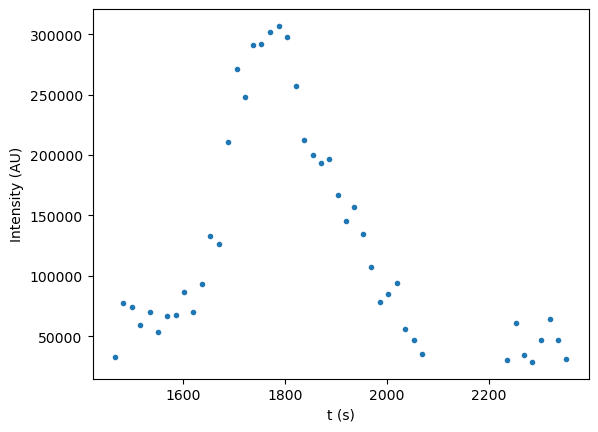

In [45]:
plt.plot(time, intensity, '.')
plt.xlabel('t (s)')
plt.ylabel('Intensity (AU)')
plt.show()